In [1]:
import random

import numpy as np
from sklearn.datasets import load_iris
import sys
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from math import sqrt
from sklearn.neighbors import KNeighborsClassifier
from scipy.integrate import quad
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


<ipython-input-2-384bc746a4c4>:361: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  print('Train Destiller: ', np.sum(atlasNN.predict(x_train) == y_train).astype(np.float) / x_train.shape[0])


Train Destiller:  0.9555555555555556
(7425,)


<ipython-input-2-384bc746a4c4>:328: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=x[y == cl, 0], y=x[y == cl, 1], alpha=0.6, color=cmap(idx), marker=markers[idx], label=cl,


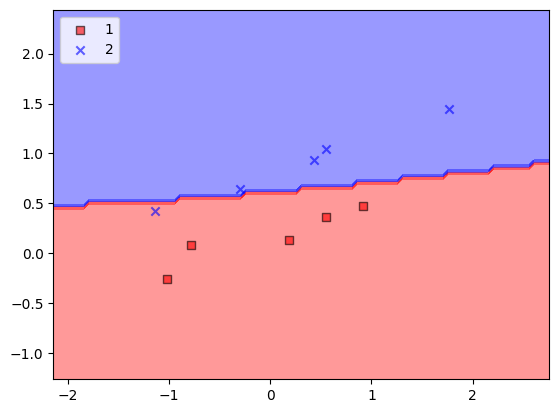

In [2]:
class Dense_Layer:
    def __init__(self, input_size, n_neurons):
        epsilon_init = 0.12
        # self.w = np.random.rand(input_size, n_neurons) * 2 * epsilon_init - epsilon_init
        self.input_size = input_size
        self.n_neurons = n_neurons
        self.w = np.random.RandomState(1).normal(loc=0.0, scale=0.1, size=(input_size, n_neurons))
        self.b = np.ones((1, n_neurons))
        # self.w = np.random.rand(input_size, n_neurons) * 0.01


        # Adam parameters
        #
        self.Vdw_prev = 0
        self.Vdb_prev = 0
        self.Sdw_prev = 0
        self.Sdb_prev = 0
        self.t = 1

        # epsilon_init = 0.12
        # self.w = np.random.rand(input_size, n_neurons) * 2 * epsilon_init - epsilon_init


    def forward(self, dense_input):
        self.z = np.dot(dense_input, self.w) + self.b
        return self.z

    def output_layer_forward(self, dense_input, adapter_bias=None):
        if adapter_bias != None:
          # np.array(adapter_bias).ravel()*2
          # [-10.80684524, -0.75234755, -12.71254801]
          # [0.9990838, -0.05951001, 0.80374069]
          self.z = np.dot(dense_input, self.w) + ((self.b - np.array(adapter_bias.theta.ravel())*(-3)))
        else:
          self.z = np.dot(dense_input, self.w) + self.b

        return self.z

    def dropout(self, activation):
        self.keep_rate = 0.75
        # self.dropout2_mask = np.random.randn(activation.shape[0], activation.shape[1]) < self.keep_rate

        self.dropout_mask = np.ones(shape=(activation.shape[0], activation.shape[1])).reshape((1, -1)) == 1

        # print(self.dropout_mask)
        inactive_neurons = int(self.dropout_mask.shape[1] - (self.dropout_mask.shape[1] * self.keep_rate))
        inactive_neurons_indices = sorted(random.sample(range(0, self.dropout_mask.shape[1]), inactive_neurons))

        self.dropout_mask[0][inactive_neurons_indices] = 0
        self.dropout_mask = self.dropout_mask.reshape(activation.shape[0], activation.shape[1])

        # activation1 = (activation * self.dropout2_mask) / self.keep_rate
        activation *= self.dropout_mask
        return activation


    def adam(self, B1, B2, EPSILON, dw, db, eta):
        Vdw = B1 * self.Vdw_prev + (1 - B1) * dw
        Vdb = B1 * self.Vdb_prev + (1 - B1) * db

        # Vdw = Vdw / (1 - B1 ** self.t)
        # Vdb = Vdb / (1 - B1 ** self.t)

        self.Vdw_prev = Vdw
        self.Vdb_prev = Vdb

        Sdw = B2 * self.Sdw_prev + (1 - B2) * (dw ** 2)
        Sdb = B2 * self.Sdb_prev + (1 - B2) * (db ** 2)

        # Sdw = Sdw / (1 - B2 ** self.t)
        # Sdb = Sdb / (1 - B2 ** self.t)

        self.Sdw_prev = Sdw
        self.Sdb_prev = Sdb


        self.t += 1

        self.w -= eta * (Vdw / (sqrt(Sdw.sum()) + EPSILON))
        self.b -= eta * (Vdb / (sqrt(Sdb.sum()) + EPSILON))

    def adam_output(self, B1, B2, EPSILON, dw, db, eta):
        Vdw = B1 * self.Vdw_prev + (1 - B1) * dw
        Vdb = B1 * self.Vdb_prev + (1 - B1) * db

        # Vdw += 0.001
        # Vdw = Vdw / (1 - B1 ** self.t)
        # Vdb = Vdb / (1 - B1 ** self.t)

        self.Vdw_prev = Vdw
        self.Vdb_prev = Vdb

        Sdw = B2 * self.Sdw_prev + (1 - B2) * (dw ** 2)
        Sdb = B2 * self.Sdb_prev + (1 - B2) * (db ** 2)

        # Sdw = Sdw / (1 - B2 ** self.t)
        # Sdb = Sdb / (1 - B2 ** self.t)

        self.Sdw_prev = Sdw
        self.Sdb_prev = Sdb

        self.t += 1

        self.w -= eta * (Vdw / (sqrt(Sdw.sum()) + EPSILON))
        self.b -= eta * (Vdb / (sqrt(Sdb.sum()) + EPSILON))


class AtlasNN:

    def __init__(self, n_hidden=2, epochs=150, eta=0.005, l2=0.01, batch_size=3, seed=1, adapter_weights=None, adapter_bias=None):
        self.n_hidden = n_hidden
        self.batch_size = batch_size
        self.epochs = epochs
        self.eta = eta
        self.l2 = l2
        self.random = np.random.RandomState(1)
        self.adapter_weights = adapter_weights
        self.adapter_bias = adapter_bias
        if self.adapter_weights != None:
          self.aaa = self.adapter_weights / np.sum(self.adapter_weights, axis=1, keepdims=True)
        self.i = 0

    def one_hot(self, y, n_classes):
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
          onehot[val, idx] = 1.
        return onehot.T


    def relu(self, z):
        return np.maximum(0, z)

    def derivative_relu(self, x):
        return np.array(x > 0,  dtype=np.float32)

    def tanh(self, z):
      return np.tanh(z)

    def derivative_tanh(self, z):
        return (1 - np.power(z, 2))

    def sigmoid(self, z):
        return (1 / (1 + np.exp(-z)))

    def derivative_sigmoid(self, z):
        return z * (1 - z)


    def softmax(self, z, x_data, y_data, num_examples):
        scores = z
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return probs

    def fit(self, x_data, y_data):
        self.h1_layer = Dense_Layer(x_data.shape[1], 100)
        self.h2_layer = Dense_Layer(100, 100)
        self.h3_layer = Dense_Layer(100, 50)
        self.h4_layer = Dense_Layer(50, 50)
        self.output_layer = Dense_Layer(50, 3)

        step_size = self.eta
        reg = 0.02

        #Adam params
        B1 = 0.9
        B2 = 0.999
        EPSILON = 1e-10
        batch_size = self.batch_size#32

        self.train_scores = []
        self.test_scores = []

        i = 0

        y_train_one_hot = self.one_hot(y_data, 3)

        for i in range(self.epochs):

            indices = np.arange(x_data.shape[0])
            np.random.shuffle(indices)

            for idx in range(0, indices.shape[0] - batch_size + 1, batch_size):
              batch_idx = indices[idx:idx + batch_size]

              z1 = self.h1_layer.forward(x_data[batch_idx])
              h1 = self.sigmoid(z1)
              # h1 = self.h1_layer.dropout(h1)

              z2 = self.h2_layer.forward(h1)
              h2 = self.sigmoid(z2)
              h2 = self.h2_layer.dropout(h2)

              z3 = self.h3_layer.forward(h2)
              h3 = self.relu(z3)

              z4 = self.h4_layer.forward(h3)
              h4 = self.relu(z4)
              h4 = self.h4_layer.dropout(h4)

              z5 = self.output_layer.output_layer_forward(h4)


              dscores = self.softmax(z5, x_data[batch_idx], y_data[batch_idx], x_data[batch_idx].shape[0])

              ###
              ##
              #   BACKPROPAGATION
              ##
              ###
              dz_out = dscores - y_train_one_hot[batch_idx]
              dw_out = np.dot(h4.T, dz_out)
              db_out = np.sum(dscores, axis=0, keepdims=True)


              dz4 = np.dot(dz_out, self.output_layer.w.T) * self.derivative_relu(h4)
              dz4 = dz4 * self.h4_layer.dropout_mask
              dw4 = np.dot(h3.T, dz4)
              db4 = np.sum(dz4, axis=0, keepdims=True)

              dz3 = np.dot(dz4, self.h4_layer.w.T) * self.derivative_relu(h3)
              dw3 = np.dot(h2.T, dz3)
              db3 = np.sum(dz3, axis=0, keepdims=True)

              ###### hidden layer error #####
              dz2 = np.dot(dz3, self.h3_layer.w.T) * self.derivative_sigmoid(h2)
              # dz2 = np.dot(dz3, self.h3_layer.w.T) * self.derivative_relu(h2)
              # dh2[h2 <= 0] = 0

              # dh2 = dh2 * self.h2_layer.dropout_mask / self.h2_layer.keep_rate
              # self.h2_layer.dropout(dh2)

              #### !!!! dropout in backpropagation !!!!! ######
              dz2 = dz2 * self.h2_layer.dropout_mask
              dw2 = np.dot(h1.T, dz2)
              db2 = np.sum(dz2, axis=0, keepdims=True)

              ### -----> should be after of before gradient calculation <----- ####
              # dh2 = dh2 * self.h2_layer.dropout_mask

              ###### hidden layer error #####
              dz1 = np.dot(dz2, self.h2_layer.w.T) * self.derivative_sigmoid(h1)
              # dz1 = np.dot(dz2, self.h2_layer.w.T) * self.derivative_relu(h1)
              # dh1[dh1 <= 0] = 0

              # dh1 = dh1 * self.h1_layer.dropout_mask / self.h1_layer.keep_rate
              # dh1 = dh1 * self.h1_layer.dropout_mask
              # self.h1_layer.dropout(dh1)

              dw1 = np.dot(x_data[batch_idx].T, dz1)
              db1 = np.sum(dz1, axis=0, keepdims=True)

              # without - elipse decision boundary, with - straight line
              # dw_out += self.l2 * self.output_layer.w
              # dw2 += self.l2 * self.h2_layer.w

              self.h1_layer.adam_output(B1, B2, EPSILON, dw1, db1, step_size)

              self.h2_layer.adam(B1, B2, EPSILON, dw2, db2, step_size)

              self.h3_layer.adam(B1, B2, EPSILON, dw3, db3, step_size)

              self.h4_layer.adam(B1, B2, EPSILON, dw4, db4, step_size)

              self.output_layer.adam(B1, B2, EPSILON, dw_out, db_out, step_size)

            # train_pred = self.predict(x_data)
            # train_acc = accuracy_score(train_pred, y_train)
            # self.train_scores.append(train_acc)

            # test_pred = self.predict(x_test_data)
            # test_acc = accuracy_score(test_pred, y_test)
            # self.test_scores.append(test_acc)
            # print('accuracy: %.2f' % (np.mean(predicted_class == y_test_data)))

    def predict(self, x):
        z1 = self.h1_layer.forward(x)
        h1 = self.sigmoid(z1)

        z2 = self.h2_layer.forward(h1)
        h2 = self.sigmoid(z2)

        z3 = self.h3_layer.forward(h2)
        h3 = self.relu(z3)

        z4 = self.h4_layer.forward(h3)
        h4 = self.relu(z4)

        scores = self.output_layer.forward(h4)

        predicted_class = np.argmax(scores, axis=1)
        return predicted_class

    def predict_scores(self, x):
        z1 = self.h1_layer.forward(x)
        h1 = self.sigmoid(z1)

        z2 = self.h2_layer.forward(h1)
        h2 = self.sigmoid(z2)

        z3 = self.h3_layer.forward(h2)
        h3 = self.relu(z3)

        z4 = self.h4_layer.forward(h3)
        h4 = self.relu(z4)

        return self.output_layer.forward(h4)

    def plot_decision_regions(self, x, y, test_idx=None, resolution=0.05):
        markers = ('s', 'x', 'o', '^', 'v')
        colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
        cmap = ListedColormap(colors[:len(np.unique(y))])

        # x = x[:, :2]
        x1_min, x1_max = x[:, 0].min() - 1, x[:, 0].max() + 1
        x2_min, x2_max = x[:, 1].min() - 1, x[:, 1].max() + 1
        xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                               np.arange(x2_min, x2_max, resolution))
        z = self.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
        print(z.shape)
        z = z.reshape(xx1.shape)
        plt.contourf(xx1, xx2, z, alpha=0.4, cmap=cmap)
        plt.xlim(xx1.min(), xx1.max())
        plt.ylim(xx2.min(), xx2.max())

        a = {0: 'Setosa', 1: 'Versicolor', 2: 'Virginica'}
        for idx, cl in enumerate(np.unique(y)):
            plt.scatter(x=x[y == cl, 0], y=x[y == cl, 1], alpha=0.6, color=cmap(idx), marker=markers[idx], label=cl,
                        edgecolors='black')
        plt.legend(loc='upper left')



iris = load_iris()
x = iris.data
y = iris.target

std = StandardScaler()
x = std.fit_transform(x)
x = x[50:]
y = y[50:]
x_train, x_test, y_train, y_test = train_test_split(x[:, [0, 2]], y, test_size=0.1, random_state=1, stratify=y)

# x_train, x_test, y_train, y_test = train_test_split(x[:, [0, 2]], y, test_size=0.4, random_state=1, stratify=y)
# x_train = x[50:, [0, 2]]
# y_train = y[50:]

# x_test = x[50:, [0, 2]]
# y_test = y[50:]

# indices = np.arange(x.shape[0])
# np.random.shuffle(indices)
# # indices = [57, 83, 33, 24, 43, 58, 50, 56, 55, 32]
# indices = [10, 70, 30, 40, 90, 55, 21, 45, 33, 32]
# x_train = x_train[indices]
# y_train = y_train[indices]

epoch=300
atlasNN = AtlasNN(eta=0.02, epochs=epoch, batch_size=5)
atlasNN.fit(x_train, y_train)
print('Train Destiller: ', np.sum(atlasNN.predict(x_train) == y_train).astype(np.float) / x_train.shape[0])
atlasNN.plot_decision_regions(x_test, y_test)
# plt.show()


------------------------------------------------------------------
-2.1430169111851116
2.7650119794625185
-1.260315415264304
2.4448073921437903
(19, 25)
(30000,)


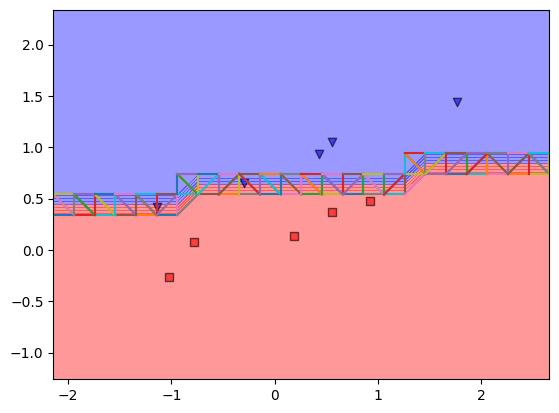

In [3]:
class Triangulation():


  def tesselation(self):

    """
    Inner methods used to compute intersection between tesselation line
    and triangulation edge
    """
    def ccw(A,B,C):
      return (C.y-A.y) * (B.x-A.x) > (B.y-A.y) * (C.x-A.x)

    def intersect(boundary, edge):
      A = boundary.v0
      B = boundary.v1
      C = edge.v0
      D = edge.v1
      return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)

    tesselationList = []
    print('Tesselation is active')
    print(f'Triangulation size: {np.array(self.triangulation).shape}')

    """
    Loop check if edges of triangles are shared, then save it's circumcenters
    to draw tesselation. If shared edge intersect with tesselation centers,
    then draw line between circumcenters. If not then draw line from
    circumcenter to triangle edges.
    """
    # plt.xlim(-2, 2)
    # plt.ylim(-2, 2)

    # app = []
    # for t in self.triangulation:
    #   if int(t.circumcenter[0]) > 5 or int(t.circumcenter[1]) > 5 or int(t.circumcenter[0]) < -5 or int(t.circumcenter[1]) < -5:
    #     print(f'Remove triangle with circumcenter: {t.circumcenter[0]}, {t.circumcenter[1]}')
    #   else:
    #     app.append(t)

    # self.triangulation = app
    # x_p = []
    # y_p = []
    # for t in self.triangulation:
    #   print(f'Triangle: <{t.v0.x}, {t.v0.y}>,  <{t.v1.x}, {t.v1.y}>,  <{t.v2.x}, {t.v2.y}>, circumcenter: <{t.circumcenter[0]}, {t.circumcenter[1]}>')
    #   x_p.append(t.v0.x)
    #   x_p.append(t.v1.x)
    #   x_p.append(t.v2.x)
    #   x_p.append(t.circumcenter[0])
    #   y_p.append(t.v0.y)
    #   y_p.append(t.v1.y)
    #   y_p.append(t.v2.y)
    #   y_p.append(t.circumcenter[1])
    #   plt.scatter(x_p, y_p)
    #   break


    for t1 in self.triangulation:
      for edge in t1.edges:
        for t2 in self.triangulation:
          if t1 == t2:
            continue
          for otherEdge in t2.edges:
            if edge.equals(otherEdge):
              tesselationList.append([t1.circumcenter, t2.circumcenter])


    # for t in tesselationList:
    #   print(f'Tesselation center: <{t[0][0]}, {t[0][1]}>, <{t[1][0]}, {t[1][1]}>')

    for t in self.triangulation:
      for edge in t.edges:
        for boundary in tesselationList:
          b_edge = Edge(Vertex(boundary[0][0], boundary[0][1]), Vertex(boundary[1][0], boundary[1][1]))
          if intersect(b_edge, edge):
            # print("Edge: <(%s, %s) : (%s, %s)> with <(%s, %s) : (%s, %s)>" % (edge.v0.x, edge.v0.y, edge.v1.x, edge.v1.y,
            #                                                                  b_edge.v0.x, b_edge.v0.y, b_edge.v1.x, b_edge.v1.y ))
            a = 0
          else:
            # print(f'Plot cords: <{t.circumcenter[0]}, {(edge.v0.x+edge.v1.x)/2}><<{t.circumcenter[1]}, {(edge.v0.y+edge.v1.y)/2}>>')
            # plt.plot([t.circumcenter[0], (edge.v0.x+edge.v1.x)/2], [t.circumcenter[1], (edge.v0.y+edge.v1.y)/2])
            break

    # for t in tesselationList:
    #   print(f'Plot cords: <{t[0][0]}, {t[0][1]}><<{t[1][0]}, {t[1][1]}>>')
    #   plt.plot([t[0][0], t[1][0]], [t[0][1], t[1][1]])


    """
    Loop finds midpoints between points with different labels
    """

    self.mid_point_list = []
    for triang in self.triangulation:
      for edge in triang.edges:
        if edge.v0.label != edge.v1.label:
          self.mid_point_list.append(Vertex((edge.v0.x+edge.v1.x)/2, (edge.v0.y+edge.v1.y)/2))


    x_scat = []
    y_scat = []
    print('Printing midpoints cords:')
    for point in self.mid_point_list:
      x_scat.append(point.x)
      y_scat.append(point.y)
      # print(f'x: {point.x}, y: {point.y}')

    plt.plot(x_scat, y_scat)
    # plt.scatter(x_scat, y_scat)

  def approximate(self):
    """
    Part used to polynomial approximation. Move to separate function
    """
    x0 = []
    y0 = []
    for point in self.mid_point_list:
      x0.append(point.x)
      y0.append(point.y)

    trainSamples = []
    for composite in zip(x0, y0):
      trainSamples.append(composite)

    sortedTrainSamples = sorted(trainSamples, key=lambda x: (x[0]))

    x1 = []
    y1 = []

    for sample in sortedTrainSamples:
      x1.append(sample[0])
      y1.append(sample[1])

    poly_features = PolynomialFeatures(degree=3, include_bias=False)

    x1 = np.array(x1)
    X_poly_2 = poly_features.fit_transform(x1.reshape(-1, 1))

    poly_reg_model = LinearRegression()
    poly_reg_model.fit(X_poly_2, y1)

    y_predicted = poly_reg_model.predict(X_poly_2)

      #create scatterplot of x vs. y
      # plt.scatter(x0, y0)           <-     middle points

      #add line to show fitted polynomial regression model
    plt.plot(x1, y_predicted, color='blue')



  def triangulate(self, points, labels):
    triangulation = []
    self.lables = labels
    self.composite = zip(points, labels)
    superTriangleA = Vertex(-10, -10, 3)
    superTriangleB = Vertex(2*10, -10, 3)
    superTriangleC = Vertex(-10, 2*10, 3)
    superTriangle = Triangle(superTriangleA,superTriangleB,superTriangleC)
    triangulation.append(superTriangle)

    i = 0
    for point in zip(points, labels):
      # print(f'Entry point {point[0]}, {point[1]}')
      i += 1
      # plt.scatter(point[0][0], point[0][1])
      badTriangles = []
      point = Vertex(point[0][0], point[0][1], point[1], True)
      # print("Searching bad triangles")
      for triangle in triangulation:
        #  print("-Triangle <%s, %s>, <%s, %s>, <%s, %s>" % (triangle.v0.x,triangle.v0.y,
        #         triangle.v1.x,triangle.v1.y, triangle.v2.x,triangle.v2.y))
         if triangle.in_circle_area(point):
          #  print('--Detect point <%s, %s> in triangle. Remove: <%s, %s>, <%s, %s>, <%s, %s>' % (point.x,point.y,triangle.v0.x,triangle.v0.y,
          #       triangle.v1.x,triangle.v1.y, triangle.v2.x,triangle.v2.y))
           badTriangles.append(triangle)

      polygon = []

      # print('Searching polygonal holes')
      #  find the boundary of the polygonal hole
      for triangle in badTriangles:
        # print("-Triangle <%s, %s>, <%s, %s>, <%s, %s>" % (triangle.v0.x,triangle.v0.y,
        #         triangle.v1.x,triangle.v1.y, triangle.v2.x,triangle.v2.y))
        for edge in triangle.edges:
          # print("--Original Edge <%s, %s>, <%s, %s>" % (edge.v0.x,edge.v0.y,
          #       edge.v1.x,edge.v1.y))
          isShared = False
          for other in badTriangles:
            # print("---Compare triangle <%s, %s>, <%s, %s>, <%s, %s>" % (other.v0.x,other.v0.y,
            #     other.v1.x,other.v1.y, other.v2.x,other.v2.y))
            if triangle == other:
              # print('****Skip the same triangle')
              continue
            for otherEdge in other.edges:
              # print("----Other Edge <%s, %s>, <%s, %s>" % (otherEdge.v0.x,otherEdge.v0.y,
              #   otherEdge.v1.x,otherEdge.v1.y))
              if edge.equals(otherEdge):
                # print('Other edge equal to original')
                isShared = True
          if isShared == False:
            # print('Not found shared edges------Next iteration of edges of "Original" triangle')
            polygon.append(edge)


      # remove them from the data structure
      for triangle in badTriangles:
        # print("Remove bad triangle <%s, %s>, <%s, %s>, <%s, %s>" % (triangle.v0.x,triangle.v0.y,
        #         triangle.v1.x,triangle.v1.y, triangle.v2.x,triangle.v2.y))
        triangulation.remove(triangle)

      # re-triangulate the polygonal hole
      for edge in polygon:
        v0_label = edge.v0.label
        v1_label = edge.v1.label
        point_label = point.label


        v0_vertex = (v0_label != v1_label) and (v0_label != point_label)# and (v1_label == point_label)
        v1_vertex = (v1_label != v0_label) and (v1_label != point_label)# and (v0_label == point_label)
        point_vertex = (point_label != v0_label) and (point_label != v1_label)# and (v0_label == v1_label)
        # if (v0_label != v1_label or v0_label != point_label or v1_label != point_label):
        # print(f'{edge.v0.label}, {edge.v1.label}, {point.label} - {len(np.unique([edge.v0.label,edge.v1.label,point.label]))}')
        # print(f'{v0_vertex}, {v1_vertex}, {point.label}')
        if v0_vertex or v1_vertex or point_vertex:
        # if len(np.unique([v0_label, v1_label, point_label])) == 2:
          newTriangle = Triangle(edge.v0,edge.v1,point)
          # t = newTriangle
          # plt.plot([t.v0.x, t.v1.x], [t.v0.y, t.v1.y])
          # plt.plot([t.v0.x, t.v2.x], [t.v0.y, t.v2.y])
          # plt.plot([t.v2.x, t.v1.x], [t.v2.y, t.v1.y])
          # print("Creating new triangle <%s, %s>, <%s, %s>, <%s, %s>" % (newTriangle.v0.x,newTriangle.v0.y,
          #       newTriangle.v1.x,newTriangle.v1.y, newTriangle.v2.x,newTriangle.v2.y))
          triangulation.append(newTriangle)
      # print('----------------------------------------------------------------------------------------------')

    to_remove = []
    for idx, triangle in enumerate(triangulation):
      if triangle.is_super_traingle_vertex(superTriangleA) and triangle in triangulation:
        to_remove.append(idx)
      if triangle.is_super_traingle_vertex(superTriangleB) and triangle in triangulation:
        to_remove.append(idx)
      if triangle.is_super_traingle_vertex(superTriangleC) and triangle in triangulation:
        to_remove.append(idx)

    res = []
    for idx, t in enumerate(triangulation):
      if idx not in to_remove:
        res.append(t)


    # for t in res:
    #   plt.scatter(t.v0.x, t.v0.y)
    #   plt.scatter(t.v1.x, t.v1.y)
    #   plt.scatter(t.v2.x, t.v2.y)
      # print(f'{t.v0.label}, {t.v1.label}, {t.v2.label} - {len(np.unique([t.v0.label,t.v1.label,t.v2.label]))}')

    # markers = ('s', 'v', 'x', '^', 'v')
    # colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    # cmap = ListedColormap(colors[:len(np.unique(y_test))])
    # for idx, cl in enumerate(np.unique(y_test)):
    #   plt.scatter(x=x_test[y_test == cl, 0], y=x_test[y_test == cl, 1], alpha=0.6, color=cmap(idx),
    #               marker=markers[idx], label=cl, edgecolors='black')

    self.triangulation = res
    # for triang in self.triangulation:
    #   if triang.v0.input_point:
    #     print(f'Point v0 corrds x: {triang.v0.x}, y: {triang.v0.y}, label: {triang.v0.label}')
    #   if triang.v1.input_point:
    #     print(f'Point v1 corrds x: {triang.v1.x}, y: {triang.v1.y}, label: {triang.v1.label}')
    #   if triang.v2.input_point:
    #     print(f'Point v2 corrds x: {triang.v2.x}, y: {triang.v2.y}, label: {triang.v2.label}')
    #   print('-----------------------------------------------------------')
    return res


class Triangle():
  def __init__(self, v0, v1, v2):
    self.v0 = v0
    self.v1 = v1
    self.v2 = v2
    # self.center, self.radius = self.circum_center()
    self.circumcenter = self.circum_center()
    self.edges = [Edge(v0, v1),Edge(v1, v2), Edge(v0, v2)]

  def is_super_traingle_vertex(self, v):
    return  self.v0 == v or self.v1 == v or self.v2 == v

  def in_circle_area(self, v):
    return sqrt((self.v0.x - self.circumcenter[0])**2 + (self.v0.y - self.circumcenter[1])**2) > sqrt((v.x - self.circumcenter[0])**2 + (v.y - self.circumcenter[1])**2)

  def circum_center(self):
    a = self.v0
    b = self.v1
    c = self.v2
    ad = a.x * a.x + a.y * a.y
    bd = b.x * b.x + b.y * b.y
    cd = c.x * c.x + c.y * c.y
    d = 2 * (a.x * (b.y - c.y) + b.x * (c.y - a.y) + c.x * (a.y - b.y))
    return (ad * (b.y - c.y) + bd * (c.y - a.y) + cd * (a.y - b.y)) / d, (ad * (c.x - b.x) + bd * (a.x - c.x) + cd * (b.x - a.x)) / d


class Edge():
  def __init__(self, v0, v1):
    self.v0 = v0
    self.v1 = v1

  def equals(self, edge):
    return (self.v0 == edge.v0 and self.v1 == edge.v1) or (self.v0 == edge.v1 and self.v1 == edge.v0)


class Vertex():
  def __init__(self, x, y, label=None, input_point=False):
    self.x = x
    self.y = y
    self.label = label
    self.input_point = input_point

  def __eq__(self, obj):
    return self.x == obj.x and self.y == obj.y



# x_train = x[50:, [0, 2]]
# y_train = y[50:]
# indices = [57, 83, 33, 24, 43, 58, 50, 56, 55, 32]
# x_test = x_train[indices]
# y_test = y_train[indices]


iris = load_iris()
x = iris.data
y = iris.target

std = StandardScaler()
x = std.fit_transform(x)

# x_train, x_test, y_train, y_test = train_test_split(x[:, [0, 2]], y, test_size=0.1, random_state=1, stratify=y)


# x_maxes = np.amax(x_train, axis=0).astype(np.float32) + 1
# x_mins = np.amin(x_train, axis=0).astype(np.float32) - 1
# vectors = [np.arange(axis_min, axis_max, 0.01)
#                    for axis_max, axis_min in zip(x_maxes, x_mins)]
# grids = np.meshgrid(*vectors)
# print(grids[0].shape)
# print(np.array(list(map(lambda array: array.ravel(), grids))).T.shape)
print('------------------------------------------------------------------')


# points = [[-1, 0],[0, -0.5],[0, 0.5], [1,0]]
points = np.array([[-1.5, 1], [2.5, 3], [3.5, 1], [4, 4], [5, 2]])
labels = [0, 0, 0, 1, 0]

# Tasks:

# 1. stworzyć siatke
# 2. predict data
# 3. na zworonych wynikach zaaplikoawc triangulacje + tesselacje + aproksymacje

# x = x_test
# print(x_test)
# p = filter(lambda s: s[1] < 0.2, x_test)
# x = np.array(list(p)).reshape(-1,2)
# print(x)

# epoch=300
# atlasNN = AtlasNN(eta=0.02, epochs=epoch, batch_size=5)
# atlasNN.fit(x_train, y_train)
# print('Train Destiller: ', np.sum(atlasNN.predict(x_train) == y_train).astype(np.float) / x_train.shape[0])

# x_idx = []
# for idx, sam in enumerate(x_test):
#   if sam[1] > 0.2:
#     x_idx.append(idx)

# print(x_idx)
# x_test = np.delete(x_test, x_idx, axis=0)
# y_test = np.delete(y_test, x_idx, axis=0)
# print(x_test)

# atlasNN.plot_decision_regions(x_test, y_test)
# plt.show()

# x = x_test
# markers = ('s', 'x', 'o', '^', 'v')
# colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
# cmap = ListedColormap(colors[:len(np.unique(y_test))])

# x1_min, x1_max = x[:, 0].min() - 1, x[:, 0].max() + 1
# x2_min, x2_max = x[:, 1].min() - 1, x[:, 1].max() + 1
# xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.02),
#                        np.arange(x2_min, x2_max, 0.02))
# print(xx1.shape)
# print(xx2.shape)
# print()


# z = atlasNN.predict(np.array([xx1.ravel(), xx2.ravel()]).T) #classes [0,1,2]
# z = z.reshape(xx1.shape)
# plt.contourf(xx1, xx2, z, alpha=0.4, cmap=cmap)
# plt.plot()


# print(z)
# z[50] = 1
# for idx, t in enumerate(z):
#   if idx > 35000 and idx < 50000:
#     z[idx] = 1
# z[100] = 1
# z[200] = 1


# z = z.reshape(xx1.shape)
# plt.contourf(xx1, xx2, z, alpha=0.4, cmap=cmap)


# markers = ('s', 'x', 'o', '^', 'v')
# colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
# cmap = ListedColormap(colors[:len(np.unique(labels))])

# x1_min, x1_max = x_test[:, 0].min() - 1, x_test[:, 0].max() + 1
# x2_min, x2_max = x_test[:, 1].min() - 1, x_test[:, 1].max() + 1
# xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.02),
#                        np.arange(x2_min, x2_max, 0.02))
# z = atlasNN.predict(np.array([xx1.ravel(), xx2.ravel()]).T) #classes [0,1,2]
# b = np.vstack((xx1.ravel(), xx2.ravel())).T
# print(b[3])
# plt.scatter(x=b[:,0], y=b[:,1])
# plt.scatter(x=xx1.ravel(), y=xx2.ravel())
# print(f'{xx1.ravel()[3]} {xx2.ravel()[3]}')
# print(z.shape)
# z = z.reshape(xx1.shape)
# plt.contourf(xx1, xx2, z, alpha=0.4, cmap=cmap)
# plt.plot()


triangulation = Triangulation()
# res = triangulation.triangulate(b, z)
# res = triangulation.triangulate(points, labels)
# triangulation.tesselation()
# print(len(res))
# print(res)

markers = ('s', 'x', 'o', '^', 'v')
colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
cmap = ListedColormap(colors[:len(np.unique(y_test))])

        # x = x[:, :2]
x1_min, x1_max = x_test[:, 0].min()-1, x_test[:, 0].max()+1
x2_min, x2_max = x_test[:, 1].min()-1, x_test[:, 1].max()+1
t_x1, t_x2 = np.meshgrid(np.arange(x1_min, x1_max, 0.2),
                         np.arange(x2_min, x2_max, 0.2))
print(x1_min)
print(x1_max)
print(x2_min)
print(x2_max)
# print(z.shape)

print(t_x1.shape)
grid = np.array([t_x1.ravel(), t_x2.ravel()]).T
# print(grid)
# plt.scatter(t_x1, t_x2)
z = atlasNN.predict(grid)
# print(z)
p = z.reshape(t_x1.shape)
# p = p[:500]
# z = z[:500]

# for point in zip(np.array([t_x1.ravel(), t_x2.ravel()]).T, z):
#   print(f'{point[0]} - {point[1]}')

plt.contourf(t_x1, t_x2, p, alpha=0.4, cmap=cmap)
res = triangulation.triangulate(grid, z)
# triangulation.tesselation()
# triangulation.approximate()
# plt.show()
# for t in res:
#   print(f'{t.v0.x}, {t.v1.x} - {t.v0.y}, {t.v1.y}')
#   print(f'{t.v0.x}, {t.v2.x} - {t.v0.y}, {t.v2.y}')
#   print(f'{t.v2.x}, {t.v1.x} - {t.v2.y}, {t.v1.y}')
#   print('-----------------------------------------------')


#------------------------------------------------------------------------------

              #2
 ###############################################################33--------

#
# x0 = [-1, 0, 1]
# x1 = [-2, -1, 0, 1, 2]
x0 = [-2, 2]
x1 = [-1, 2]

markers = ('s', 'x', 'o', '^', 'v')
colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
cmap = ListedColormap(colors[:len([0, 1])])
x0 = np.array(x0)
x1 = np.array(x1)

x1_min, x1_max = x0.min(), x0.max()
x2_min, x2_max = x1.min(), x1.max()
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.02),
                       np.arange(x2_min, x2_max, 0.02))

print(xx1.ravel().shape)
o = []
for y in range(xx1.ravel().shape[0]+1):
  if y < 170: #9500
    o.append(0)
  # if y > 120 and y < 170:
  #   o.append(1)
  if y > 170:
    o.append(1)

o[155] = 1
o[156] = 1
o[154] = 1
o[153] = 1
# for i in range(9500, 9520):
#   o[i] = 0

# for i in range(9521, 9580):
#   o[i] = 0

grid = np.array([xx1.ravel(), xx2.ravel()]).T
# z = atlasNN.predict(grid)
# l = z.reshape(xx1.shape)
l = np.array(o).reshape(xx1.shape)
# plt.contourf(xx1, xx2, l, alpha=0.4, cmap=cmap)
# plt.show()

# res = triangulation.triangulate(grid, np.array(o))
# triangulation.tesselation()

###############################################################33--------

###
    # Print dla siatki punktow

###
o = []
for y in range(100):
  if y < 40:
    o.append(0)
  # if y > 40 and y < 70:
  #   o.append(1)
  if y > 40:
    o.append(1)

x0 = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
x1 = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
# xx1, xx2 = np.meshgrid(np.array(x0), np.array(x1))
# l = np.array(o).reshape(xx1.shape)
# o[6][5] = 2
# plt.contourf(xx1, xx2, l, alpha=0.4, cmap=cmap)
# plt.scatter(xx1, xx2)

# res = triangulation.triangulate(np.vstack((xx1.ravel(), xx2.ravel())).T, np.array(o))
# res = triangulation.triangulate(np.vstack((xx1.ravel(), xx2.ravel())).T, np.array(o))
# triangulation.tesselation()


# plt.scatter(x=x_test[:,0], y=x_test[:,1])

# plt.scatter(x=points[:,0], y=points[:,1])


# import matplotlib.tri as tri
# triang = tri.Triangulation(x_test[:, 0], x_test[:, 1])
# plt.triplot(triang)

x0 = np.array([-2, 2])
x1 = np.array([-1, 2])
x1_min, x1_max = x0.min(), x0.max()
x2_min, x2_max = x1.min(), x1.max()
t_x1, t_x2 = np.meshgrid(np.arange(x1_min, x1_max, 0.3),
                         np.arange(x2_min, x2_max, 0.3))

# grid = np.array([t_x1.ravel(), t_x2.ravel()]).T
# z = atlasNN.predict(grid)
# p = z.reshape(t_x1.shape)

# plt.scatter(t_x1, t_x2)
# plt.contourf(t_x1, t_x2, p, alpha=0.4, cmap=cmap)
# res = triangulation.triangulate(grid, z)

# plt.show()
# ***
#
#   USED TO PRINT TRIANGULATION!!!!!!
# ***
for t in res:
  plt.plot([t.v0.x, t.v1.x], [t.v0.y, t.v1.y])
  plt.plot([t.v0.x, t.v2.x], [t.v0.y, t.v2.y])
  plt.plot([t.v2.x, t.v1.x], [t.v2.y, t.v1.y])

markers = ('s', 'v', 'x', '^', 'v')
colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
cmap = ListedColormap(colors[:len(np.unique(y_test))])
for idx, cl in enumerate(np.unique(y_test)):
  plt.scatter(x=x_test[y_test == cl, 0], y=x_test[y_test == cl, 1], alpha=0.6, color=cmap(idx),
              marker=markers[idx], label=cl, edgecolors='black')
plt.show()

In [ ]:
markers = ('s', 'x', 'o', '^', 'v')
colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
cmap = ListedColormap(colors[:len(np.unique(labels))])

x1_min, x1_max = x_test[:, 0].min() - 1, x_test[:, 0].max() + 1
x2_min, x2_max = x_test[:, 1].min() - 1, x_test[:, 1].max() + 1
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.02),
                       np.arange(x2_min, x2_max, 0.02))
z = atlasNN.predict(np.array([xx1.ravel(), xx2.ravel()]).T) #classes [0,1,2]
b = np.vstack((xx1.ravel(), xx2.ravel())).T
print(b.shape)
# plt.scatter(x=b[:,0], y=b[:,1])
# plt.scatter(x=xx1.ravel(), y=xx2.ravel())
# print(f'{xx1.ravel()[3]} {xx2.ravel()[3]}')
# print(z.shape)
# z = z.reshape(xx1.shape)
# plt.contourf(xx1, xx2, z, alpha=0.4, cmap=cmap)
# plt.plot()

# from scipy.spatial import Voronoi, voronoi_plot_2d
# vor = Voronoi(b)
# fig = voronoi_plot_2d(vor)
# plt.show()

triangulation = Triangulation()
res = triangulation.triangulate(b, z)
# res = triangulation.triangulate(points, labels)
triangulation.tesselation()
for t in res:
  plt.plot([t.v0.x, t.v1.x], [t.v0.y, t.v1.y])
  plt.plot([t.v0.x, t.v2.x], [t.v0.y, t.v2.y])
  plt.plot([t.v2.x, t.v1.x], [t.v2.y, t.v1.y])

In [ ]:
for v in vor.vertices:
  if v[0] > 2.5 or v[1] > 2.5:
    print(v)

# Nowa sekcja